Copyright 2019 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# NASBench-101

This colab accompanies [**NAS-Bench-101: Towards Reproducible Neural Architecture Search**](https://arxiv.org/abs/1902.09635) and the rest of the code at https://github.com/google-research/nasbench.

In this colab, we demonstrate how to use the dataset for simple benchmarking and analysis. The publicly available and free hosted colab instances are sufficient to run this colab.

## Load NASBench library and dataset

In [1]:
# This code was written in TF 1.12 but should be supported all the way through
# TF 1.15. Untested in TF 2.0+.
%tensorflow_version 1.x

# Download the raw data (only 108 epoch data points, for full dataset,
# uncomment the second line for nasbench_full.tfrecord).

!curl -O https://storage.googleapis.com/nasbench/nasbench_only108.tfrecord
# !curl -O https://storage.googleapis.com/nasbench/nasbench_full.tfrecord

# Clone and install the code and dependencies.

!git clone https://github.com/google-research/nasbench
!pip install ./nasbench

# Initialize the NASBench object which parses the raw data into memory (this
# should only be run once as it takes up to a few minutes).
from nasbench import api

# Use nasbench_full.tfrecord for full dataset (run download command above).
nasbench = api.NASBench('nasbench_only108.tfrecord')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  498M  100  498M    0     0  54.1M      0  0:00:09  0:00:09 --:--:-- 67.7M
Cloning into 'nasbench'...
remote: Enumerating objects: 92, done.
remote: Total 92 (delta 0), reused 0 (delta 0), pack-reused 92
Unpacking objects: 100% (92/92), done.
Processing ./nasbench
  Created wheel for nasbench: filename=nasbench-1.0-cp36-none-any.whl size=46791 sha256=88bafd1b9d560fd0fe9b6f8ceac03001e0b42b4dc2718648550569f654f098b3
  Stored in directory: /tmp/pip-ephem-wheel-cache-blg0rruf/wheels/4b/19/99/1d5fdfe30f8b16fab91e900808f4f7e5adc38e602c84970ad5
Successfully built nasbench



Loading dataset from file... This may take a few minutes...
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Loaded dataset in 53 seconds


In [2]:
# Initialize the NASBench object which parses the raw data into memory (this
# should only be run once as it takes up to a few minutes).
import tensorflow as tf
import sys 
# 切到 TF1 兼容模式
tf.compat.v1.disable_eager_execution()
tf.compat.v1.disable_v2_behavior()

# 关键：让后续模块看到的 "import tensorflow as tf" 就是 TF1 风格
sys.modules['tensorflow'] = tf.compat.v1

# 若你下面还要用变量名 tf，建议也指向 v1
tf = tf.compat.v1

from nasbench import api

# Use nasbench_full.tfrecord for full dataset (run download command above).
nasbench = api.NASBench('nasbench_full.tfrecord')

Instructions for updating:
non-resource variables are not supported in the long term
Loading dataset from file... This may take a few minutes...
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Loaded dataset in 43 seconds


In [3]:
# Standard imports
import copy
import numpy as np
import matplotlib.pyplot as plt
import random

# Useful constants
INPUT = 'input'
OUTPUT = 'output'
CONV3X3 = 'conv3x3-bn-relu'
CONV1X1 = 'conv1x1-bn-relu'
MAXPOOL3X3 = 'maxpool3x3'
NUM_VERTICES = 7
MAX_EDGES = 9
EDGE_SPOTS = NUM_VERTICES * (NUM_VERTICES - 1) / 2   # Upper triangular matrix
OP_SPOTS = NUM_VERTICES - 2   # Input/output vertices are fixed
ALLOWED_OPS = [CONV3X3, CONV1X1, MAXPOOL3X3]
ALLOWED_EDGES = [0, 1]   # Binary adjacency matrix

## Basic usage

In [4]:
# Query an Inception-like cell from the dataset.
cell = api.ModelSpec(
  matrix=[[0, 1, 1, 1, 0, 1, 0],    # input layer
          [0, 0, 0, 0, 0, 0, 1],    # 1x1 conv
          [0, 0, 0, 0, 0, 0, 1],    # 3x3 conv
          [0, 0, 0, 0, 1, 0, 0],    # 5x5 conv (replaced by two 3x3's)
          [0, 0, 0, 0, 0, 0, 1],    # 5x5 conv (replaced by two 3x3's)
          [0, 0, 0, 0, 0, 0, 1],    # 3x3 max-pool
          [0, 0, 0, 0, 0, 0, 0]],   # output layer
  # Operations at the vertices of the module, matches order of matrix.
  ops=[INPUT, CONV1X1, CONV3X3, CONV3X3, CONV3X3, MAXPOOL3X3, OUTPUT])

# Querying multiple times may yield different results. Each cell is evaluated 3
# times at each epoch budget and querying will sample one randomly.
data = nasbench.query(cell)
for k, v in data.items():
  print('%s: %s' % (k, str(v)))

module_adjacency: [[0 1 1 1 1 0 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0]]
module_operations: ['input', 'conv3x3-bn-relu', 'conv1x1-bn-relu', 'maxpool3x3', 'conv3x3-bn-relu', 'conv3x3-bn-relu', 'output']
trainable_parameters: 2694282
training_time: 1157.675048828125
train_accuracy: 1.0
validation_accuracy: 0.9378004670143127
test_accuracy: 0.932692289352417


In [6]:
# 1. 加载 NASBench 数据集
import nasbench.api as api

# 替换为实际的数据集文件路径
nasbench = api.NASBench('nasbench_full.tfrecord')

# 2. 遍历数据集中的唯一模型哈希值（也可直接使用已知的哈希值作为 key）
for unique_hash in nasbench.hash_iterator():
    # 3. 通过哈希值（key）查询模型信息
    fixed_metrics, computed_metrics = nasbench.get_metrics_from_hash(unique_hash)
    
    # 4. 输出模型的固定统计信息（如结构信息）
    print("模型哈希值（key）:", unique_hash)
    print("邻接矩阵:", fixed_metrics['module_adjacency'])
    print("操作序列:", fixed_metrics['module_operations'])
    print("可训练参数数量:", fixed_metrics['trainable_parameters'])
    
    # 5. 输出模型的计算统计信息（如不同轮次的性能）
    for epochs in nasbench.valid_epochs:
        for repeat_index in range(len(computed_metrics[epochs])):
            data_point = computed_metrics[epochs][repeat_index]
            print(f"训练{epochs}轮，第{repeat_index + 1}次重复:")
            print("最终测试准确率:", data_point['final_test_accuracy'])
            print("训练时间:", data_point['final_training_time'])
    
    # 为避免输出过多，此处仅遍历第一个模型后退出
    break

Loading dataset from file... This may take a few minutes...
Loaded dataset in 43 seconds
模型哈希值（key）: 00005c142e6f48ac74fdcf73e3439874
邻接矩阵: [[0 1 0 0 1 1 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 1]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0]]
操作序列: ['input', 'conv3x3-bn-relu', 'maxpool3x3', 'conv3x3-bn-relu', 'conv3x3-bn-relu', 'conv1x1-bn-relu', 'output']
可训练参数数量: 8555530
训练108轮，第1次重复:
最终测试准确率: 0.9211738705635071
训练时间: 1769.1279296875
训练108轮，第2次重复:
最终测试准确率: 0.9190705418586731
训练时间: 1768.2509765625
训练108轮，第3次重复:
最终测试准确率: 0.9215745329856873
训练时间: 1768.9759521484375
训练4轮，第1次重复:
最终测试准确率: 0.3504607379436493
训练时间: 89.90399932861328
训练4轮，第2次重复:
最终测试准确率: 0.31870993971824646
训练时间: 90.87100219726562
训练4轮，第3次重复:
最终测试准确率: 0.3530648946762085
训练时间: 89.80400085449219
训练12轮，第1次重复:
最终测试准确率: 0.6185897588729858
训练时间: 216.27999877929688
训练12轮，第2次重复:
最终测试准确率: 0.4196714758872986
训练时间: 215.625
训练12轮，第3次重复:
最终测试准确率: 0.42327722907066345
训练时间: 220.11300659179688
训练36轮，第1次重复:
最终测试准确率: 0.8817107

In [ ]:
import nasbench.api as api
# 1) 加载 NASBench
nasbench = api.NASBench('nasbench_full.tfrecord')
print(f"✅ 数据集加载完成，可用评估 epoch：{nasbench.valid_epochs}")

In [ ]:

import numpy as np
import pickle

OP_TYPES = ['input','conv1x1-bn-relu','conv3x3-bn-relu','maxpool3x3','output']

def compute_flops(matrix, ops, input_channels=3, output_channels=16):
    flops = 0
    num_vertices = len(ops)
    channels = [input_channels] + [output_channels]*(num_vertices-2) + [output_channels]
    H = W = 32
    for i in range(num_vertices):
        for j in range(num_vertices):
            if matrix[i][j] == 1 and ops[i] != 'input' and ops[j] != 'output':
                op = ops[i]
                if op == 'conv1x1-bn-relu':
                    flops += (1*1*channels[i]) * channels[j] * (H*W)
                elif op == 'conv3x3-bn-relu':
                    flops += (3*3*channels[i]) * channels[j] * (H*W)
    return int(flops)

def op_to_onehot(op, op_list):
    onehot = [0]*len(op_list)
    if op in op_list:
        onehot[op_list.index(op)] = 1
    return onehot


# 目标 epoch：108
target_epochs = 108
if target_epochs not in nasbench.valid_epochs:
    raise ValueError(f"目标 epoch={target_epochs} 不在可用列表 {nasbench.valid_epochs} 中")

results = {}

for idx, unique_hash in enumerate(nasbench.hash_iterator()):
    fixed_metrics, computed_metrics = nasbench.get_metrics_from_hash(unique_hash)

    matrix = fixed_metrics['module_adjacency'].tolist()
    ops = fixed_metrics['module_operations']
    params = int(fixed_metrics['trainable_parameters'])
    flops = compute_flops(np.array(matrix), ops)
    node_ids = [OP_TYPES.index(op) for op in ops]

    mean_metrics = {}
    if target_epochs in computed_metrics:
        repeats = computed_metrics[target_epochs]  # list[dict]
        if repeats:
            values = [float(rep.get('final_test_accuracy', 0.0)) for rep in repeats]
            mean_metrics['final_test_accuracy'] = float(np.mean(values))
    accuracy = mean_metrics['final_test_accuracy']
    results[idx] = {
        'adjacency_matrix': matrix,
        'node_operations': ops,
        'node_ids': node_ids,
        'params': params,
        'flops': flops,
        'accuracy': accuracy
    }
    if (idx + 1) % 1000 == 0:
        print(f"已处理 {idx + 1} 个模型")

out_path = f'../nasbench101_acc.pkl'
with open(out_path, 'wb') as f:
    pickle.dump(results, f, protocol=pickle.HIGHEST_PROTOCOL)
print(f"✨ 已保存到 {out_path}，共 {len(results)} 个条目")

Loading dataset from file... This may take a few minutes...
Loaded dataset in 47 seconds
✅ 数据集加载完成，可用评估 epoch：{108, 4, 12, 36}
已处理 1000 个模型
已处理 2000 个模型
已处理 3000 个模型
已处理 4000 个模型
已处理 5000 个模型
已处理 6000 个模型
已处理 7000 个模型
已处理 8000 个模型
已处理 9000 个模型
已处理 10000 个模型
已处理 11000 个模型
已处理 12000 个模型
已处理 13000 个模型
已处理 14000 个模型
已处理 15000 个模型
已处理 16000 个模型
已处理 17000 个模型
已处理 18000 个模型
已处理 19000 个模型
已处理 20000 个模型
已处理 21000 个模型
已处理 22000 个模型
已处理 23000 个模型
已处理 24000 个模型
已处理 25000 个模型
已处理 26000 个模型
已处理 27000 个模型
已处理 28000 个模型
已处理 29000 个模型
已处理 30000 个模型
已处理 31000 个模型
已处理 32000 个模型
已处理 33000 个模型
已处理 34000 个模型
已处理 35000 个模型
已处理 36000 个模型
已处理 37000 个模型
已处理 38000 个模型
已处理 39000 个模型
已处理 40000 个模型
已处理 41000 个模型
已处理 42000 个模型
已处理 43000 个模型
已处理 44000 个模型
已处理 45000 个模型
已处理 46000 个模型
已处理 47000 个模型
已处理 48000 个模型
已处理 49000 个模型
已处理 50000 个模型
已处理 51000 个模型
已处理 52000 个模型
已处理 53000 个模型
已处理 54000 个模型
已处理 55000 个模型
已处理 56000 个模型
已处理 57000 个模型
已处理 58000 个模型
已处理 59000 个模型
已处理 60000 个模型
已处理 61000 个模型
已处理 62000 个模型
已处理 63000 个模型


In [31]:
out_path = f'../nasbench101_acc.pkl'
with open(out_path, 'wb') as f:
    pickle.dump(results, f, protocol=pickle.HIGHEST_PROTOCOL)
print(f"✨ 已保存到 {out_path}，共 {len(results)} 个条目")

✨ 已保存到 ../nasbench101_acc.pkl，共 423624 个条目


In [32]:
out_path = f'../nasbench101_acc.pkl'
with open(out_path, 'rb') as f:
    df = pickle.load(f)
df

{0: {'adjacency_matrix': [[0, 1, 0, 0, 1, 1, 0],
   [0, 0, 1, 0, 0, 0, 0],
   [0, 0, 0, 1, 0, 0, 1],
   [0, 0, 0, 0, 0, 1, 0],
   [0, 0, 0, 0, 0, 1, 0],
   [0, 0, 0, 0, 0, 0, 1],
   [0, 0, 0, 0, 0, 0, 0]],
  'node_operations': ['input',
   'conv3x3-bn-relu',
   'maxpool3x3',
   'conv3x3-bn-relu',
   'conv3x3-bn-relu',
   'conv1x1-bn-relu',
   'output'],
  'node_ids': [0, 2, 3, 2, 2, 1, 4],
  'params': 8555530,
  'flops': 7077888,
  'accuracy': 0.9206063151359558},
 1: {'adjacency_matrix': [[0, 1, 0, 0, 0, 0, 0],
   [0, 0, 1, 0, 0, 0, 0],
   [0, 0, 0, 1, 0, 0, 0],
   [0, 0, 0, 0, 1, 1, 1],
   [0, 0, 0, 0, 0, 1, 0],
   [0, 0, 0, 0, 0, 0, 1],
   [0, 0, 0, 0, 0, 0, 0]],
  'node_operations': ['input',
   'conv1x1-bn-relu',
   'conv1x1-bn-relu',
   'conv3x3-bn-relu',
   'conv1x1-bn-relu',
   'conv3x3-bn-relu',
   'output'],
  'node_ids': [0, 1, 1, 2, 1, 2, 4],
  'params': 5878154,
  'flops': 5505024,
  'accuracy': 0.8864516615867615},
 2: {'adjacency_matrix': [[0, 1, 0, 0, 0, 1, 0],
   [0, 0

## Example search experiment (random vs. evolution)

In [0]:
def random_spec():
  """Returns a random valid spec."""
  while True:
    matrix = np.random.choice(ALLOWED_EDGES, size=(NUM_VERTICES, NUM_VERTICES))
    matrix = np.triu(matrix, 1)
    ops = np.random.choice(ALLOWED_OPS, size=(NUM_VERTICES)).tolist()
    ops[0] = INPUT
    ops[-1] = OUTPUT
    spec = api.ModelSpec(matrix=matrix, ops=ops)
    if nasbench.is_valid(spec):
      return spec

def mutate_spec(old_spec, mutation_rate=1.0):
  """Computes a valid mutated spec from the old_spec."""
  while True:
    new_matrix = copy.deepcopy(old_spec.original_matrix)
    new_ops = copy.deepcopy(old_spec.original_ops)

    # In expectation, V edges flipped (note that most end up being pruned).
    edge_mutation_prob = mutation_rate / NUM_VERTICES
    for src in range(0, NUM_VERTICES - 1):
      for dst in range(src + 1, NUM_VERTICES):
        if random.random() < edge_mutation_prob:
          new_matrix[src, dst] = 1 - new_matrix[src, dst]
          
    # In expectation, one op is resampled.
    op_mutation_prob = mutation_rate / OP_SPOTS
    for ind in range(1, NUM_VERTICES - 1):
      if random.random() < op_mutation_prob:
        available = [o for o in nasbench.config['available_ops'] if o != new_ops[ind]]
        new_ops[ind] = random.choice(available)
        
    new_spec = api.ModelSpec(new_matrix, new_ops)
    if nasbench.is_valid(new_spec):
      return new_spec

def random_combination(iterable, sample_size):
  """Random selection from itertools.combinations(iterable, r)."""
  pool = tuple(iterable)
  n = len(pool)
  indices = sorted(random.sample(range(n), sample_size))
  return tuple(pool[i] for i in indices)

def run_random_search(max_time_budget=5e6):
  """Run a single roll-out of random search to a fixed time budget."""
  nasbench.reset_budget_counters()
  times, best_valids, best_tests = [0.0], [0.0], [0.0]
  while True:
    spec = random_spec()
    data = nasbench.query(spec)

    # It's important to select models only based on validation accuracy, test
    # accuracy is used only for comparing different search trajectories.
    if data['validation_accuracy'] > best_valids[-1]:
      best_valids.append(data['validation_accuracy'])
      best_tests.append(data['test_accuracy'])
    else:
      best_valids.append(best_valids[-1])
      best_tests.append(best_tests[-1])

    time_spent, _ = nasbench.get_budget_counters()
    times.append(time_spent)
    if time_spent > max_time_budget:
      # Break the first time we exceed the budget.
      break

  return times, best_valids, best_tests

def run_evolution_search(max_time_budget=5e6,
                         population_size=50,
                         tournament_size=10,
                         mutation_rate=1.0):
  """Run a single roll-out of regularized evolution to a fixed time budget."""
  nasbench.reset_budget_counters()
  times, best_valids, best_tests = [0.0], [0.0], [0.0]
  population = []   # (validation, spec) tuples

  # For the first population_size individuals, seed the population with randomly
  # generated cells.
  for _ in range(population_size):
    spec = random_spec()
    data = nasbench.query(spec)
    time_spent, _ = nasbench.get_budget_counters()
    times.append(time_spent)
    population.append((data['validation_accuracy'], spec))

    if data['validation_accuracy'] > best_valids[-1]:
      best_valids.append(data['validation_accuracy'])
      best_tests.append(data['test_accuracy'])
    else:
      best_valids.append(best_valids[-1])
      best_tests.append(best_tests[-1])

    if time_spent > max_time_budget:
      break

  # After the population is seeded, proceed with evolving the population.
  while True:
    sample = random_combination(population, tournament_size)
    best_spec = sorted(sample, key=lambda i:i[0])[-1][1]
    new_spec = mutate_spec(best_spec, mutation_rate)

    data = nasbench.query(new_spec)
    time_spent, _ = nasbench.get_budget_counters()
    times.append(time_spent)

    # In regularized evolution, we kill the oldest individual in the population.
    population.append((data['validation_accuracy'], new_spec))
    population.pop(0)

    if data['validation_accuracy'] > best_valids[-1]:
      best_valids.append(data['validation_accuracy'])
      best_tests.append(data['test_accuracy'])
    else:
      best_valids.append(best_valids[-1])
      best_tests.append(best_tests[-1])

    if time_spent > max_time_budget:
      break

  return times, best_valids, best_tests
  

In [5]:
# Run random search and evolution search 10 times each. This should take a few
# minutes to run. Note that each run would have taken days of compute to
# actually train and evaluate if the dataset were not precomputed.
random_data = []
evolution_data = []
for repeat in range(10):
  print('Running repeat %d' % (repeat + 1))
  times, best_valid, best_test = run_random_search()
  random_data.append((times, best_valid, best_test))

  times, best_valid, best_test = run_evolution_search()
  evolution_data.append((times, best_valid, best_test))

Running repeat 1
Running repeat 2
Running repeat 3
Running repeat 4
Running repeat 5
Running repeat 6
Running repeat 7
Running repeat 8
Running repeat 9
Running repeat 10


Text(0.5, 1.0, 'Evolution search trajectories (red=validation, blue=test)')

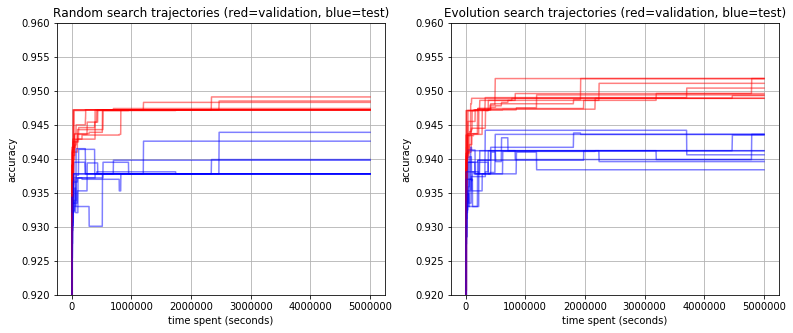

In [6]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
for times, best_valid, best_test in random_data:
  plt.plot(times, best_valid, label='valid', color='red', alpha=0.5)
  plt.plot(times, best_test, label='test', color='blue', alpha=0.5)

plt.ylabel('accuracy')
plt.xlabel('time spent (seconds)')
plt.ylim(0.92, 0.96)
plt.grid()
plt.title('Random search trajectories (red=validation, blue=test)')


plt.subplot(1, 3, 2)
for times, best_valid, best_test in evolution_data:
  plt.plot(times, best_valid, label='valid', color='red', alpha=0.5)
  plt.plot(times, best_test, label='test', color='blue', alpha=0.5)

plt.ylabel('accuracy')
plt.xlabel('time spent (seconds)')
plt.ylim(0.92, 0.96)
plt.grid()
plt.title('Evolution search trajectories (red=validation, blue=test)')

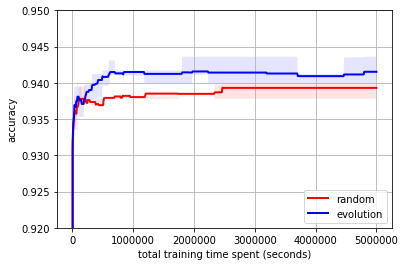

In [7]:
# Compare the mean test accuracy along with error bars.
def plot_data(data, color, label, gran=10000, max_budget=5000000):
  """Computes the mean and IQR fixed time steps."""
  xs = range(0, max_budget+1, gran)
  mean = [0.0]
  per25 = [0.0]
  per75 = [0.0]
  
  repeats = len(data)
  pointers = [1 for _ in range(repeats)]
  
  cur = gran
  while cur < max_budget+1:
    all_vals = []
    for repeat in range(repeats):
      while (pointers[repeat] < len(data[repeat][0]) and 
             data[repeat][0][pointers[repeat]] < cur):
        pointers[repeat] += 1
      prev_time = data[repeat][0][pointers[repeat]-1]
      prev_test = data[repeat][2][pointers[repeat]-1]
      next_time = data[repeat][0][pointers[repeat]]
      next_test = data[repeat][2][pointers[repeat]]
      assert prev_time < cur and next_time >= cur

      # Linearly interpolate the test between the two surrounding points
      cur_val = ((cur - prev_time) / (next_time - prev_time)) * (next_test - prev_test) + prev_test
      
      all_vals.append(cur_val)
      
    all_vals = sorted(all_vals)
    mean.append(sum(all_vals) / float(len(all_vals)))
    per25.append(all_vals[int(0.25 * repeats)])
    per75.append(all_vals[int(0.75 * repeats)])
      
    cur += gran
    
  plt.plot(xs, mean, color=color, label=label, linewidth=2)
  plt.fill_between(xs, per25, per75, alpha=0.1, linewidth=0, facecolor=color)

plot_data(random_data, 'red', 'random')
plot_data(evolution_data, 'blue', 'evolution')
plt.legend(loc='lower right')
plt.ylim(0.92, 0.95)
plt.xlabel('total training time spent (seconds)')
plt.ylabel('accuracy')
plt.grid()

## More information

For more information on using the dataset, see the API documentation at https://github.com/google-research/nasbench/blob/master/nasbench/api.py.
